In [73]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from cryptovision.tools import (
    image_directory_to_pandas,
    split_image_dataframe,
    tf_dataset_from_pandas,
    predict_image,
)

In [74]:
settings = dict(
    batch_size = 64,
    epochs = 10,
    ftun_epochs = 10,
    img_size = (384, 384),
    seed = 42,
    ftun_last_layers = 70,
    ftune_learning_rate = 0.00001,
    
)

df = image_directory_to_pandas("/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset")

train_df, val_df, test_df = split_image_dataframe(df, test_size=0.15, val_size=0.15, stratify_by='folder_label')

# Display the sizes of each split
print(f"Training Sample size: {len(train_df)}")
print(f"Validation Sample size: {len(val_df)}")
print(f"Test Sample size: {len(test_df)}")

train_ds, family_labels, genus_labels, species_labels = tf_dataset_from_pandas(train_df, settings['batch_size'], settings['img_size'])  
val_ds, _, _, _ = tf_dataset_from_pandas(val_df, settings['batch_size'], settings['img_size'])
test_ds, _, _, _ = tf_dataset_from_pandas(test_df, settings['batch_size'], settings['img_size'])

Training Sample size: 6314
Validation Sample size: 1353
Test Sample size: 1354


In [75]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [76]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)


In [34]:
from tensorflow.keras.applications import ResNet50V2  

from tensorflow.keras.layers import ( # type: ignore
    Dense, GlobalAveragePooling2D, Dropout,
    BatchNormalization, Activation, Multiply,
    Add, Concatenate, Input, Reshape, Layer, Attention,
    MultiHeadAttention, Conv2D, MaxPooling2D, Flatten,
)

# Base Model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(384, 384, 3))
base_model.trainable = False

#preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

inputs = tf.keras.Input(shape=(384, 384, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
rn_features_extracted = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(rn_features_extracted)
x = tf.keras.layers.Dropout(0.2)(x)


# Shared dense layer for better feature learning
shared_layer = tf.keras.layers.Dense(512, activation=None, name='shared_layer')(x)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)
shared_layer = Dropout(0.3)(shared_layer)

# Family output
family_conv = Conv2D(64, (3, 3), activation='relu', padding='same')(rn_features_extracted)
family_pool = MaxPooling2D((2, 2))(family_conv)
family_flatten = Flatten()(family_pool)
family_features = Concatenate()([shared_layer, family_flatten])
family_output = Dense(len(family_labels), activation='softmax', name='family')(family_flatten)

# Genus output
genus_conv = Conv2D(128, (3, 3), activation='relu', padding='same')(rn_features_extracted)
genus_pool = MaxPooling2D((2, 2))(genus_conv)
genus_flatten = Flatten()(genus_pool)
genus_features = Concatenate()([shared_layer, family_flatten, genus_flatten])
genus_output = Dense(len(genus_labels), activation='softmax', name='genus')(genus_features)

# Genus output
species_conv = Conv2D(256, (3, 3), activation='relu', padding='same')(rn_features_extracted)
species_pool = MaxPooling2D((2, 2))(species_conv)
species_flatten = Flatten()(species_pool)
species_features = Concatenate()([shared_layer, family_flatten, genus_flatten, species_flatten])
species_output = Dense(len(species_labels), activation='softmax', name='species')(species_features)


# Model
model = tf.keras.Model(inputs, [family_output, genus_output, species_output])


# Compile the model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss = 'categorical_crossentropy',
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_52      │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 384, 384,  │          0 │ input_layer_52[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_18      │ (None, 384, 384,  │          0 │ sequential_1[16]… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_18         │ (None, 384, 384,  │          0 │ true_divide_18[0… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 12, 12,    │ 23,564,800 │ subtract_18[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 2048)      │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 512)       │  1,049,088 │ dropout_30[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 12, 12,    │  1,179,712 │ resnet50v2[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ shared_layer[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 12, 12,    │  2,359,424 │ resnet50v2[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 12, 12,    │  4,718,848 │ resnet50v2[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_102   │ (None, 6, 6, 64)  │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_103   │ (None, 6, 6, 128) │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_104   │ (None, 6, 6, 256) │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 2304)      │          0 │ max_pooling2d_10

 Total params: 34,198,072 (130.46 MB)

 Trainable params: 10,632,248 (40.56 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

In [35]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

2024-12-03 17:00:57.484310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 940ms/step - family_AUC: 0.5083 - family_Precision: 0.0353 - family_Recall: 0.0264 - family_accuracy: 0.0361 - family_loss: 6.5530 - genus_AUC: 0.4781 - genus_Precision: 0.0178 - genus_Recall: 0.0067 - genus_accuracy: 0.0137 - genus_loss: 7.1853 - loss: 20.6219 - species_AUC: 0.5313 - species_Precision: 0.0179 - species_Recall: 0.0059 - species_accuracy: 0.0306 - species_loss: 6.8969

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.035 / Loss: 6.537

Genus Accuracy: 0.016 / Loss: 7.122

Species Accuracy: 0.027 / Loss: 6.923




In [36]:
history = model.fit(
    train_ds,
    epochs=settings['epochs'],
    validation_data=val_ds,
    batch_size=settings['batch_size'],
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - family_AUC: 0.7549 - family_Precision: 0.3983 - family_Recall: 0.1486 - family_accuracy: 0.2896 - family_loss: 2.8922 - genus_AUC: 0.7428 - genus_Precision: 0.4662 - genus_Recall: 0.1097 - genus_accuracy: 0.2377 - genus_loss: 3.7543 - loss: 10.2650 - species_AUC: 0.7916 - species_Precision: 0.5422 - species_Recall: 0.1917 - species_accuracy: 0.2967 - species_loss: 3.6137 - val_family_AUC: 0.9463 - val_family_Precision: 0.7960 - val_family_Recall: 0.4701 - val_family_accuracy: 0.6334 - val_family_loss: 1.2448 - val_genus_AUC: 0.9654 - val_genus_Precision: 0.8782 - val_genus_Recall: 0.5011 - val_genus_accuracy: 0.6401 - val_genus_loss: 1.3103 - val_loss: 3.6922 - val_species_AUC: 0.9717 - val_species_Precision: 0.8477 - val_species_Recall: 0.5965 - val_species_accuracy: 0.6948 - val_species_loss: 1.1636
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - family_AUC: 0.9477 - family_Precision: 0.7891 - family_Recall: 0.4920 - family_ac

In [37]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 933ms/step - family_AUC: 0.9940 - family_Precision: 0.9371 - family_Recall: 0.8941 - family_accuracy: 0.9106 - family_loss: 0.2893 - genus_AUC: 0.9947 - genus_Precision: 0.9375 - genus_Recall: 0.8845 - genus_accuracy: 0.8963 - genus_loss: 0.3340 - loss: 1.0803 - species_AUC: 0.9911 - species_Precision: 0.9183 - species_Recall: 0.8704 - species_accuracy: 0.8822 - species_loss: 0.4536

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.919 / Loss: 0.278

Genus Accuracy: 0.904 / Loss: 0.338

Species Accuracy: 0.887 / Loss: 0.411




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


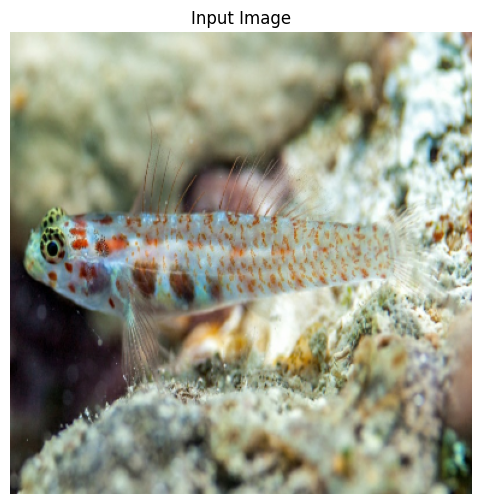

Top 3 Family Predictions:
b'Gobiidae': 0.9974
b'Tripterygiidae': 0.0026
b'Chaenopsidae': 0.0000

Top 3 Genus Predictions:
b'Eviota': 0.9944
b'Fusigobius': 0.0032
b'Ecsenius': 0.0006

Top 3 Species Predictions:
b'Eviota melasma': 0.5795
b'Eviota albolineata': 0.2862
b'Enneanectes matador': 0.0425


In [38]:
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset/Gobiidae_Eviota_melasma/web_Eviota_melasma_41.jpeg'

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3, image_size=settings['img_size']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


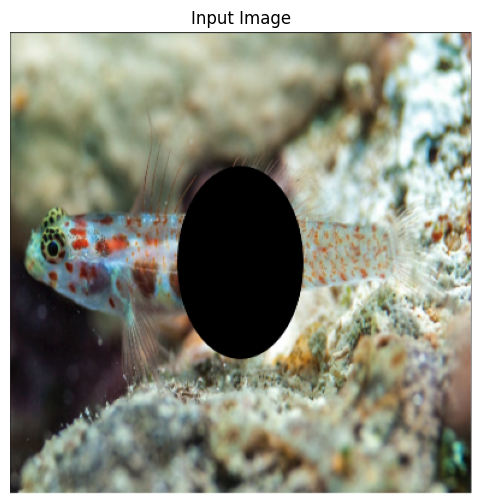

Top 3 Family Predictions:
Gobiidae: 0.4089
Pomacentridae: 0.3102
Creediidae: 0.0498

Top 3 Genus Predictions:
Chromis: 0.3153
Canthigaster: 0.1747
Corythoichthys: 0.1363

Top 3 Species Predictions:
Chromis_margaritifer: 0.9228
Acanthemblemaria_aspera: 0.0428
Canthigaster_solandri: 0.0128


In [62]:
image_path = '/Users/leonardo/Desktop/easy.png'

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=3, image_size=settings['img_size']
)

In [39]:
import os
import numpy as np
from collections import defaultdict
import pandas as pd
import tensorflow as tf

def get_taxonomic_mappings_from_folders(data_dir):
    """
    Extract family, genus, and species mappings from the dataset folder structure.
    
    Args:
    - data_dir (str): Path to the training dataset directory.
    
    Returns:
    - family_labels (list): List of unique family names.
    - genus_labels (list): List of unique genus names.
    - species_labels (list): List of unique species names.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    """
    family_labels = set()
    genus_labels = set()
    species_labels = set()
    genus_to_family = {}
    species_to_genus = {}

    # Iterate through the folders in the data directory
    for folder_name in os.listdir(data_dir):
        # Assume folder names are in the format "family_genus_species"
        parts = folder_name.split('_')
        if len(parts) == 3:
            family, genus, species = parts
            family_labels.add(family)
            genus_labels.add(genus)
            species_full = f"{genus}_{species}"
            species_labels.add(species_full)

            # Map genus to family
            genus_to_family[genus] = family

            # Map species to genus
            species_to_genus[species_full] = genus

    # Sort the labels to maintain consistent ordering
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    return family_labels, genus_labels, species_labels, genus_to_family, species_to_genus

def analyze_taxonomic_misclassifications(model, dataset, family_labels, genus_labels, species_labels, genus_to_family, species_to_genus):
    """
    Analyze misclassifications of a trained model to check if taxonomic hierarchies are respected.
    
    Args:
    - model (tf.keras.Model): The trained model.
    - dataset (tf.data.Dataset): Validation or test dataset.
    - family_labels, genus_labels, species_labels (list): List of class labels for family, genus, and species.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    
    Returns:
    - summary (dict): A dictionary containing summary of misclassifications.
    - genus_df (DataFrame): DataFrame with genus misclassification details.
    - species_df (DataFrame): DataFrame with species misclassification details.
    """
    # Counters for misclassifications
    genus_misclassifications = defaultdict(int)
    genus_respect_family = 0
    genus_total_mistakes = 0

    species_misclassifications = defaultdict(int)
    species_respect_genus = 0
    species_respect_family = 0
    species_total_mistakes = 0

    # Iterate over the dataset to collect predictions and true labels
    for images, labels in dataset:
        # Get the logits from the model for each output (family, genus, species)
        family_logits, genus_logits, species_logits = model(images, training=False)

        # Get true and predicted labels for each level
        true_family_indices = tf.argmax(labels['family'], axis=1).numpy()
        true_genus_indices = tf.argmax(labels['genus'], axis=1).numpy()
        true_species_indices = tf.argmax(labels['species'], axis=1).numpy()

        pred_family_indices = np.argmax(family_logits, axis=1)
        pred_genus_indices = np.argmax(genus_logits, axis=1)
        pred_species_indices = np.argmax(species_logits, axis=1)

        # Analyze genus misclassifications
        for true_genus_idx, pred_genus_idx in zip(true_genus_indices, pred_genus_indices):
            if true_genus_idx != pred_genus_idx:
                genus_total_mistakes += 1
                true_genus = genus_labels[true_genus_idx]
                pred_genus = genus_labels[pred_genus_idx]

                # Count the misclassification
                genus_misclassifications[(true_genus, pred_genus)] += 1

                # Check if the misclassified genus is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)  # Use .get() in case pred_genus is missing
                if true_family == pred_family:
                    genus_respect_family += 1

        # Analyze species misclassifications
        for true_species_idx, pred_species_idx in zip(true_species_indices, pred_species_indices):
            if true_species_idx != pred_species_idx:
                species_total_mistakes += 1
                true_species = species_labels[true_species_idx]
                pred_species = species_labels[pred_species_idx]

                # Count the misclassification
                species_misclassifications[(true_species, pred_species)] += 1

                # Check if the misclassified species is in the same genus
                true_genus = species_to_genus[true_species]
                pred_genus = species_to_genus.get(pred_species, None)
                if true_genus == pred_genus:
                    species_respect_genus += 1

                # Check if the misclassified species is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)
                if true_family == pred_family:
                    species_respect_family += 1

    # Calculate percentages of misclassifications that respect the hierarchy
    genus_hierarchy_respect_pct = (genus_respect_family / genus_total_mistakes) * 100 if genus_total_mistakes > 0 else 0
    species_hierarchy_respect_genus_pct = (species_respect_genus / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0
    species_hierarchy_respect_family_pct = (species_respect_family / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0

    # Create a summary of the analysis
    summary = {
        'genus_total_mistakes': genus_total_mistakes,
        'genus_hierarchy_respect': genus_respect_family,
        'genus_hierarchy_respect_pct': genus_hierarchy_respect_pct,
        'genus_misclassifications': dict(genus_misclassifications),
        'species_total_mistakes': species_total_mistakes,
        'species_hierarchy_respect_genus': species_respect_genus,
        'species_hierarchy_respect_genus_pct': species_hierarchy_respect_genus_pct,
        'species_hierarchy_respect_family': species_respect_family,
        'species_hierarchy_respect_family_pct': species_hierarchy_respect_family_pct,
        'species_misclassifications': dict(species_misclassifications),
    }

    # Convert misclassification dictionaries to DataFrames for better readability
    genus_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in genus_misclassifications.items()],
        columns=['True Genus', 'Predicted Genus', 'Count']
    ).sort_values(by='Count', ascending=False)

    species_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in species_misclassifications.items()],
        columns=['True Species', 'Predicted Species', 'Count']
    ).sort_values(by='Count', ascending=False)

    # Print the summaries
    print(f"Genus Misclassifications: {genus_total_mistakes}")
    print(f"Genus Misclassifications Respecting Family: {genus_respect_family} ({genus_hierarchy_respect_pct:.2f}%)")
    print(f"\nTop Genus Misclassifications:\n{genus_df.head(10)}")

    print(f"\nSpecies Misclassifications: {species_total_mistakes}")
    print(f"Species Misclassifications Respecting Genus: {species_respect_genus} ({species_hierarchy_respect_genus_pct:.2f}%)")
    print(f"Species Misclassifications Respecting Family: {species_respect_family} ({species_hierarchy_respect_family_pct:.2f}%)")
    print(f"\nTop Species Misclassifications:\n{species_df.head(10)}")

    return summary, genus_df, species_df

# Example usage:
# Assuming 'train_dir' is the path to the training dataset directory.
train_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"
family_labels, genus_labels, species_labels, genus_to_family, species_to_genus = get_taxonomic_mappings_from_folders(train_dir)

# Now analyze the misclassifications using the mappings
summary, genus_df, species_df = analyze_taxonomic_misclassifications(
    model=model,
    dataset=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
    genus_to_family=genus_to_family,
    species_to_genus=species_to_genus
)

Genus Misclassifications: 130
Genus Misclassifications Respecting Family: 42 (32.31%)

Top Genus Misclassifications:
      True Genus   Predicted Genus  Count
0        Chromis       Pomacentrus      3
5     Istigobius        Fusigobius      3
46          Ucla  Acanthemblemaria      3
13   Pomacentrus           Chromis      2
33  Neocirrhites         Chaetodon      2
32     Gomphosus       Pomacentrus      2
28        Eviota      Pristiapogon      2
78      Ecsenius            Apogon      2
42     Priolepis            Eviota      2
43      Gobiodon      Paragobiodon      2

Species Misclassifications: 153
Species Misclassifications Respecting Genus: 20 (13.07%)
Species Misclassifications Respecting Family: 61 (39.87%)

Top Species Misclassifications:
                   True Species           Predicted Species  Count
0                Eviota_melasma          Eviota_albolineata      4
96             Ucla_xenogrammus         Enneanectes_matador      4
26             Ecsenius_pulcher      Ci

2024-12-03 17:27:31.084900: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def compute_saliency_maps(img_path, model, img_size=(384, 384)):
    """
    Compute and visualize saliency maps for the predicted class with the highest value 
    for family, genus, and species, displayed side-by-side with the original image.

    Args:
    - img_path (str): Path to the input image.
    - model (tf.keras.Model): Trained model with three outputs (family, genus, species).
    - img_size (tuple): Target image size for resizing.

    Returns:
    - None. Displays the saliency maps for family, genus, and species side-by-side with the original image.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_tensor = tf.convert_to_tensor(img_array)

    # Prepare the original image for display
    original_img = img
    #original_img = np.array(img) / 255.0  # Normalize to [0, 1]

    # Map output types to model output indices
    output_mapping = {'family': 0, 'genus': 1, 'species': 2}

    # Store saliency maps
    saliency_maps = {}

    # Generate saliency maps for each output type
    for output_type, output_index in output_mapping.items():
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            outputs = model(img_tensor)  # Multi-output prediction
            preds = outputs[output_index]
            class_indices = tf.argmax(preds, axis=-1)[0]  # Select class with the highest prediction value
            loss = preds[:, class_indices]

        grads = tape.gradient(loss, img_tensor)

        # Compute the mean of the absolute gradients across the color channels
        saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

        # Normalize the saliency map
        saliency = saliency.numpy()
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize to [0, 1]

        # Store the saliency map
        saliency_maps[output_type] = saliency

    # Plot the original image and saliency maps
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(original_img)
    plt.axis('off')
    plt.title("Original Image")

    for i, (output_type, saliency) in enumerate(saliency_maps.items(), start=2):
        plt.subplot(1, 4, i)
        #plt.imshow(original_img)
        plt.imshow(saliency, cmap='jet', alpha=1)
        plt.axis('off')
        plt.title(f"{output_type.capitalize()} Saliency")

    plt.tight_layout()
    plt.show()

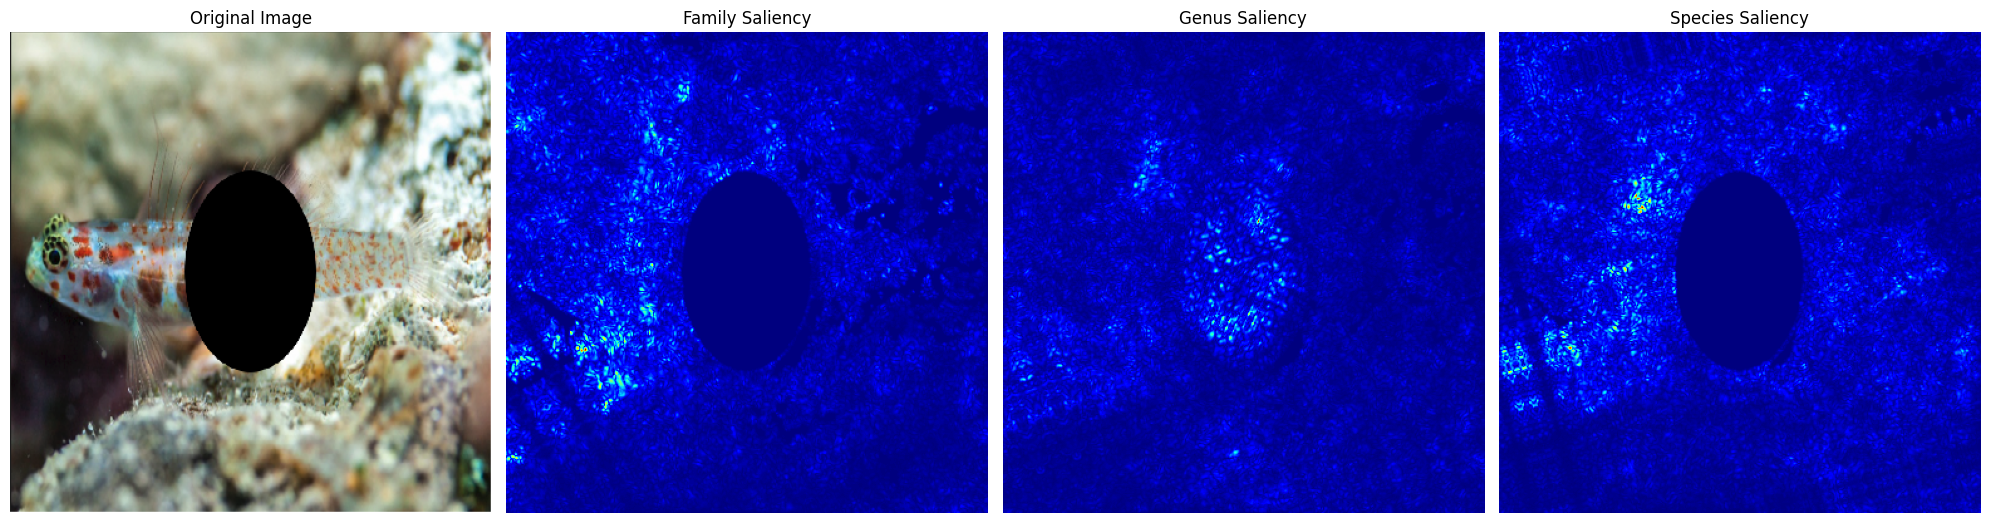

In [71]:
compute_saliency_maps(image_path, model)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Activation

def plot_gradcam(model, img_array, output_labels, output_names, layer_names, class_idx=None, cmap="viridis"):
    """
    Plot Grad-CAM for each specified output layer.

    Parameters:
        model (tf.keras.Model): The trained hierarchical model.
        img_array (np.ndarray): Preprocessed input image array (e.g., after normalization).
        output_labels (list of int): Target labels for each output.
        output_names (list of str): Names of the output layers (e.g., "family", "genus", "species").
        layer_names (list of str): Names of the last convolutional layers for each output.
        class_idx (list of int): Class indices to visualize (defaults to predicted classes if None).
        cmap (str): Colormap for the heatmap.
    """
    for i, (output_label, output_name, layer_name) in enumerate(zip(output_labels, output_names, layer_names)):
        # Access the last convolutional layer
        last_conv_layer = model.get_layer(layer_name)
        grad_model = Model(
            [model.inputs],
            [last_conv_layer.output, model.get_layer(output_name).output]
        )
        
        # Compute gradients
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            target_class = class_idx[i] if class_idx else np.argmax(predictions[0])
            loss = predictions[:, target_class]

        grads = tape.gradient(loss, conv_outputs)  # Gradients of loss wrt conv outputs
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

        # Weight the conv outputs by the pooled grads
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

        # Normalize the heatmap
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        # Resize the heatmap to the size of the input image
        heatmap = tf.image.resize(heatmap[..., np.newaxis], (img_array.shape[1], img_array.shape[2]))
        heatmap = tf.squeeze(heatmap).numpy()

        # Overlay the heatmap on the input image
        img = img_array[0]  # Get the first image (assuming batch size of 1)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.imshow(heatmap, cmap=cmap, alpha=0.5)
        plt.title(f"Grad-CAM for {output_name} (Class: {target_class})")
        plt.axis("off")
        plt.show()

# Example Usage:
# Assuming `model` is your trained hierarchical model
# Assuming `preprocessed_image` is a preprocessed single image with shape (1, 224, 224, 3)

layer_names = ["conv2d", "conv2d_1", "conv2d_2"]  # Replace with actual last conv layer names
output_names = ["family", "genus", "species"]    # Output layer names
output_labels = [5, 10, 20]  # Replace with target labels for family, genus, and species (example)

plot_gradcam(model, preprocessed_image, output_labels, output_names, layer_names)

In [79]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Dropout, 
    BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten, 
    Concatenate, Add, Attention, Reshape
)

def hierarchical_model(
    n_families, 
    n_genera, 
    n_species,
    input_shape=(224, 224, 3),
    base_weights="imagenet",
    base_trainable=False,
    shared_layer_neurons=512,
    shared_layer_dropout=0.3,
    genus_hidden_neurons=256,
    species_hidden_neurons=128
):
    # Base Model (ResNet50v2 backbone)
    base_model = ResNet50V2(include_top=False, weights=base_weights, input_shape=input_shape)
    base_model.trainable = base_trainable

    # Input and base model processing
    inputs = Input(shape=input_shape)
    x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    rn_features_extracted = x  # Retain spatial features from ResNet

    # Global pooling for shared feature extraction
    shared_features = GlobalAveragePooling2D()(x)
    shared_features = Dense(shared_layer_neurons, activation=None, name='shared_layer')(shared_features)
    shared_features = BatchNormalization()(shared_features)
    shared_features = Activation('relu')(shared_features)
    shared_features = Dropout(shared_layer_dropout)(shared_features)

    # Attention Layer (Optional for enhancing shared features)
    shared_features_reshaped = Reshape((1, shared_layer_neurons))(shared_features)
    attention_output = Attention()([shared_features_reshaped, shared_features_reshaped])
    attention_output = Reshape((shared_layer_neurons,))(attention_output)  # Reshape back to 2D
    shared_features = Add()([shared_features, attention_output])  # Residual connection

    # Family output with task-specific Conv2D processing
    family_conv = Conv2D(64, (3, 3), activation='relu', padding='same')(rn_features_extracted)
    family_pool = MaxPooling2D((2, 2))(family_conv)
    family_flatten = Flatten()(family_pool)
    family_features = Concatenate()([shared_features, family_flatten])
    family_output = Dense(n_families, activation='softmax', name='family')(family_features)

    # Genus output
    genus_conv = Conv2D(128, (3, 3), activation='relu', padding='same')(rn_features_extracted)
    genus_pool = MaxPooling2D((2, 2))(genus_conv)
    genus_flatten = Flatten()(genus_pool)
    genus_features = Concatenate()([shared_features, family_output, genus_flatten])
    genus_hidden = Dense(genus_hidden_neurons, activation='relu')(genus_features)
    genus_output = Dense(n_genera, activation='softmax', name='genus')(genus_hidden)

    # Species output
    species_conv = Conv2D(256, (3, 3), activation='relu', padding='same')(rn_features_extracted)
    species_pool = MaxPooling2D((2, 2))(species_conv)
    species_flatten = Flatten()(species_pool)
    species_features = Concatenate()([shared_features, family_output, genus_output, species_flatten])
    species_hidden = Dense(species_hidden_neurons, activation='relu')(species_features)
    species_output = Dense(n_species, activation='softmax', name='species')(species_hidden)

    # Create the hierarchical model
    model = tf.keras.Model(inputs, [family_output, genus_output, species_output])

    return model

# Example usage
model_conv = hierarchical_model(
    n_families=18, 
    n_genera=45, 
    n_species=57, 
    input_shape=(224, 224, 3), 
    base_weights="imagenet", 
    base_trainable=False
)

# Compile the model
model_conv.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics={
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    }
)

# Model Summary
model_conv.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_22      │ (None, 224, 224,  │          0 │ input_layer_60[0… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_22         │ (None, 224, 224,  │          0 │ true_divide_22[0… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ subtract_22[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 512)       │  1,049,088 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ shared_layer[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 512)       │          0 │ activation_19[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 512)    │          0 │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 1, 512)    │          0 │ reshape_6[0][0],  │
│ (Attention)         │                   │            │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 7, 7, 64)  │  1,179,712 │ resnet50v2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 512)       │          0 │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_126   │ (None, 3, 3, 64)  │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 512)       │          0 │ dropout_35[0][0], │
│                     │                   │            │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_36          │ (None, 576)       │          0 │ max_pooling2d_12… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 7, 7, 128) │  2,359,424 │ resnet50v2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 1088)      │          0 │ add_3[0][0],      │
│ (Concatenate)       │                   │            │ flatten_36[0][0]

 Total params: 33,711,928 (128.60 MB)

 Trainable params: 10,146,104 (38.70 MB)

 Non-trainable params: 23,565,824 (89.90 MB)